# 读取2月的FNL文件风场，与模拟结果、观测结果比较

* Author: Evan
* date: 2023-04-26

In [26]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
from config import projectdir, datapath
import ModelEvaLib as me

In [2]:
fnl = xr.open_dataset(datapath+'fnl_Feb.nc')
fnl

<xarray.Dataset>
Dimensions:        (time: 112, isobaricInhPa: 33, latitude: 181, longitude: 360)
Coordinates:
  * time           (time) datetime64[ns] 2023-02-01T08:00:00 ... 2023-03-01T0...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (time) datetime64[ns] ...
Data variables:
    gh             (time, isobaricInhPa, latitude, longitude) float32 ...
    t              (time, isobaricInhPa, latitude, longitude) float32 ...
    r              (time, isobaricInhPa, latitude, longitude) float32 ...
    q              (time, isobaricInhPa, latitude, longitude) float32 ...
    w              (time, isobaricInhPa, latitude, longitude) float32 ...
    wz             (time, isobaricInhPa, latitude, longitude) float32 ...
    u              (time, isobaricInhPa, latitude, longitude) float32 ...
    v              (time, isobaricInhPa, latitude, longitude) float32 ...
    absv           (time, isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-04-26T10:22 GRIB to CDM+CF via cfgrib-0.9.1...

## 根据站点位置提取FNL数据

In [3]:
siteloc = pd.read_excel(projectdir+'obs_202302_fromlzj/安庆市站点坐标.xlsx',header=0,index_col=0)
lono = siteloc['经度']
lato = siteloc['纬度']

In [12]:
u = fnl.u.sel(isobaricInhPa=1000,longitude=lono.values,latitude=lato.values,method='nearest').mean(dim=['latitude','longitude'])
v = fnl.v.sel(isobaricInhPa=1000,longitude=lono.values,latitude=lato.values,method='nearest').mean(dim=['latitude','longitude'])
ws = np.sqrt(u**2+v**2)

## 提取模拟与观测数据

In [27]:
ncfile = datapath+'compressed_met.nc'
var    = 'WSPD10'
varch  = '风速'

shpfile = projectdir+'shapefile/Anqing/Anqing.shp'
xlsfile = projectdir+'obs_202302_fromlzj/allsite.xlsx'

df, sim, obs = me.get_var(ncfile,var,shpfile,xlsfile,varch)

Get the WSPD10 in shape of (672, 138, 135)
Extract the data within the boundary ...
Finish
Get the 风速 in shape of (672,)
data is ready


## 绘图比较

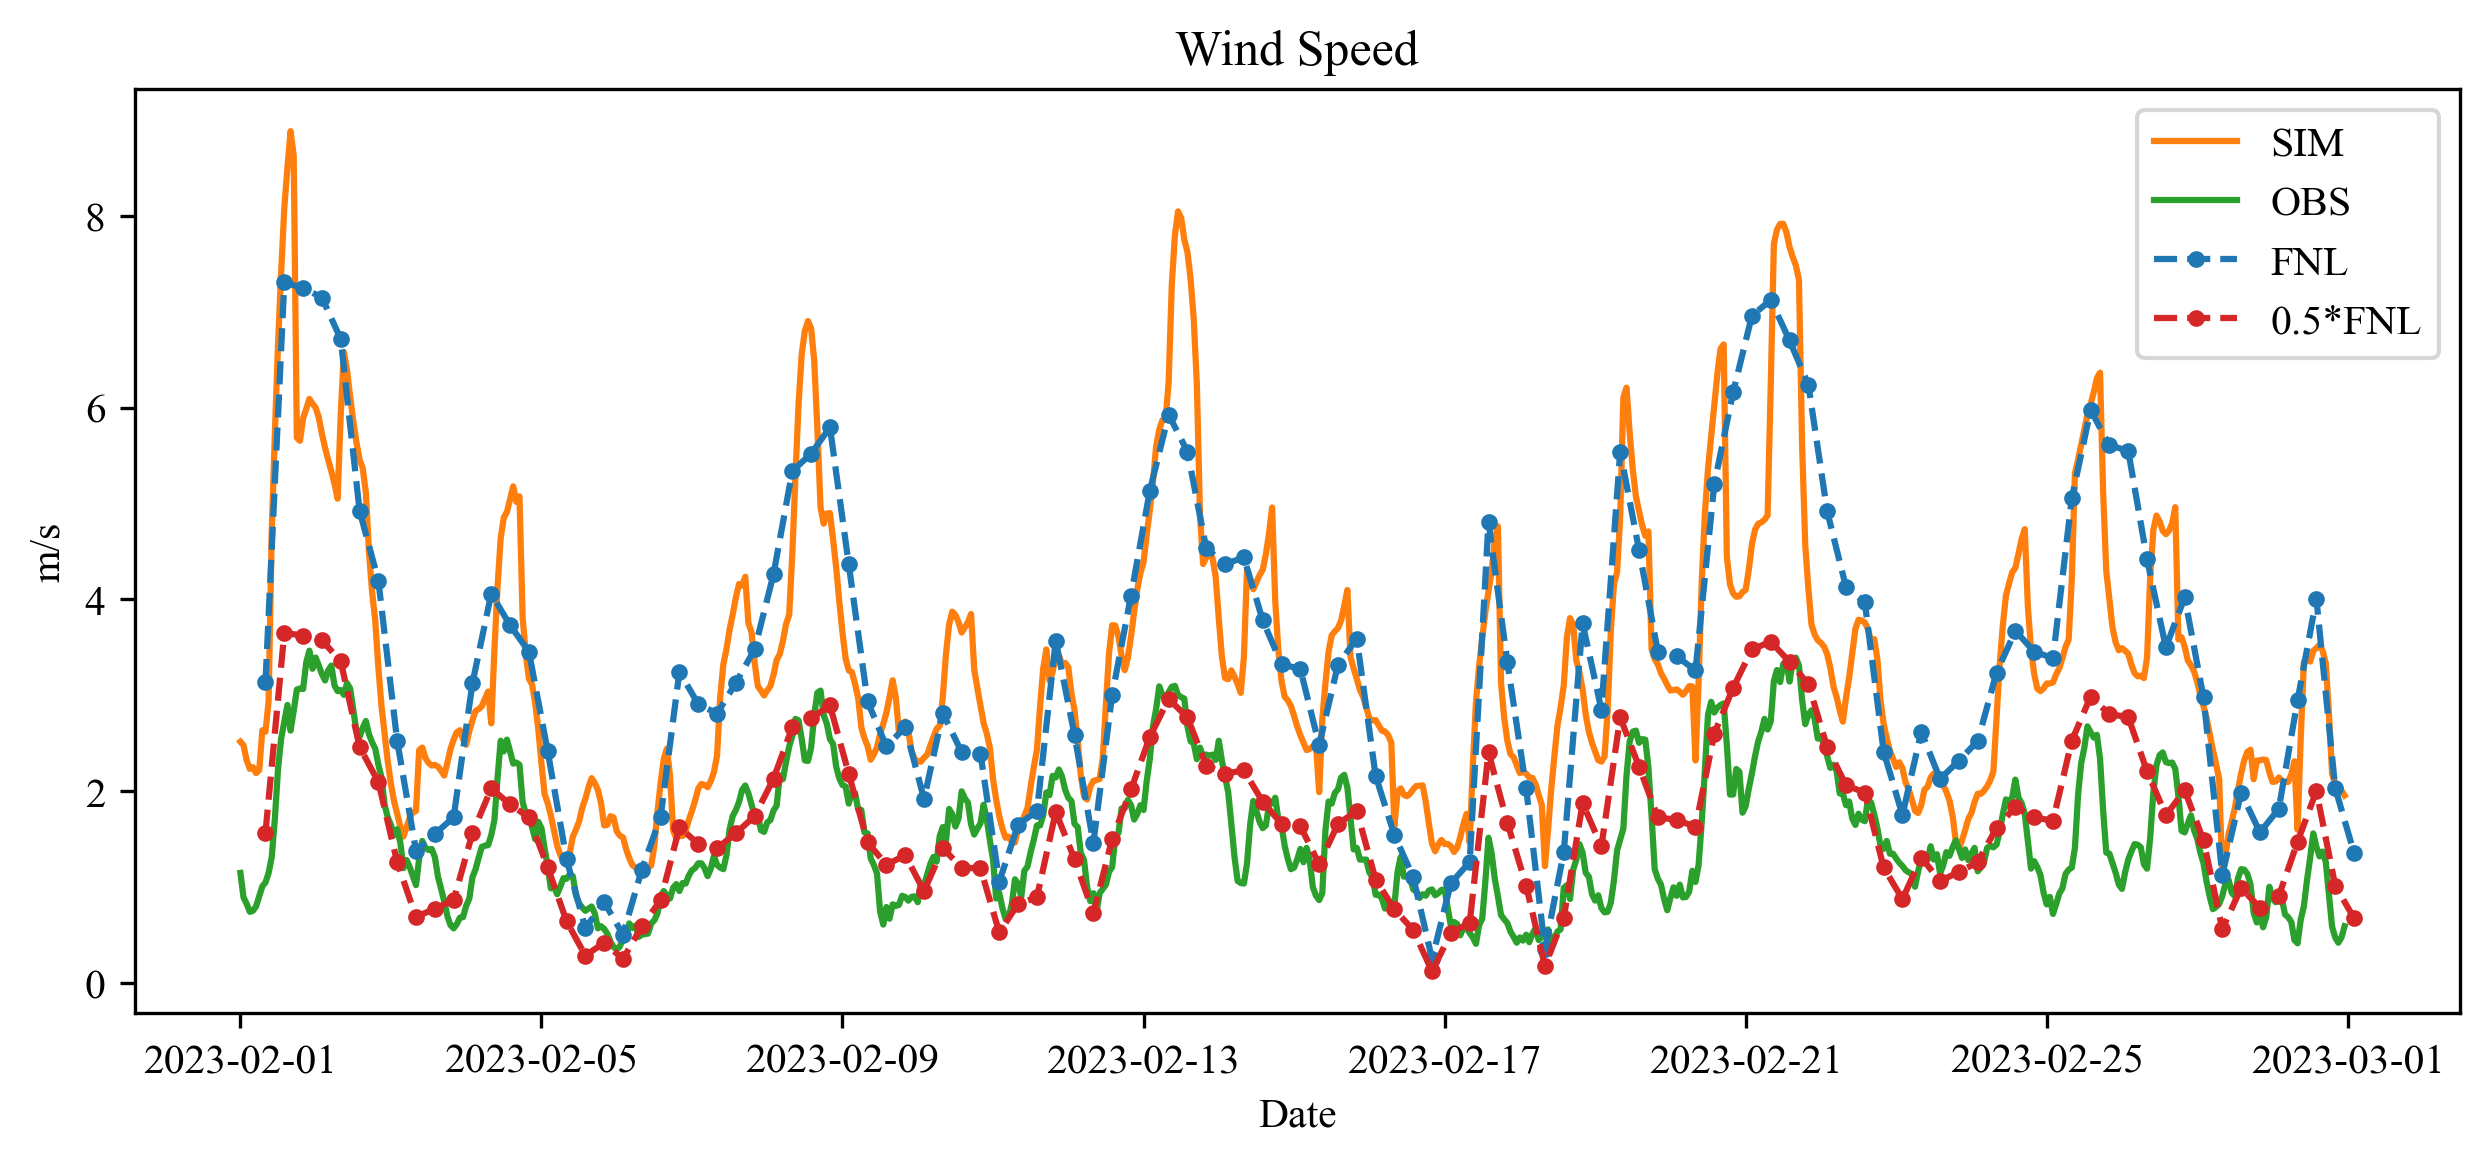

In [55]:
fig = plt.figure(figsize=(10,4),dpi=300)
ax = fig.subplots(1,1)

datetime = pd.date_range('2023-02-01T00','2023-02-28T23',freq='H')
ax.plot(datetime,sim,color='tab:orange',label='SIM')
ax.plot(datetime,obs,color='tab:green',label='OBS')
ax.plot(u.time,ws,linestyle='--',marker='.',color='tab:blue',label='FNL')
ax.plot(u.time,ws*0.5,linestyle='--',marker='.',color='tab:red',label='0.5*FNL')

ax.legend(loc=1)

ax.set_xlabel('Date')
ax.set_ylabel('m/s')
ax.set_title('Wind Speed')

plt.show()